In [56]:
# Basic Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math
from random import uniform, randint
from imblearn.over_sampling import SMOTE
import os
# os.environ["OMP_NUM_THREADS"] = "1"



# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import pickle

pd.set_option('display.max_columns', None)      # To display all the columns.
pd.set_option('display.max_rows', None)        # To display all the rows.
warnings.filterwarnings('ignore')       # To ignore all the warnings.

In [19]:
# Importing Data
telecom_df = pd.read_csv(r"F:\Projects\Real MLOps project\Telecom Customer Churn Prediction\archive\Telco_Customer_Churn.csv")

In [20]:
# Functtions For EDA

def EDA(df):
    print("Top 5 rows:")
    print(telecom_df.head())
    print("------------------------------------------------------")
    print("Bottom 5 rows:")
    print(telecom_df.tail())
    print("------------------------------------------------------")
    print("Shape Of The Data:")
    print(telecom_df.shape)
    print("------------------------------------------------------")
    print("Dimension Of The Data:")
    print(telecom_df.ndim)
    print("------------------------------------------------------")
    print("Datatype:")
    print(telecom_df.dtypes)
    print("------------------------------------------------------")
    print("Total Null Values:")
    print(telecom_df.isna().sum())
    print("------------------------------------------------------")
    print("Total Duplicate Rows:")
    print(telecom_df.duplicated().sum())
    print("------------------------------------------------------")
    print("Outliers In Data:")
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    # Set up the grid size dynamically based on number of columns
    n_cols = 3
    n_rows = 5
    
    plt.figure(figsize=(10,  n_rows))
    
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.boxplot(x=df[col], color='skyblue')
        plt.title(f'Outlier Detection: {col}', fontsize=12)
        plt.xlabel('')
    
    plt.tight_layout()
    plt.show()

In [21]:
# Function to Check Distribution
def DistCheck(feature, frame, color = 'r'):
    plt.figure(figsize= (8, 3))
    plt.title("Distribution Of {}".format(feature))
    sns.histplot(data= frame , x= feature, color= color)

In [22]:
# Function to find the best model
def BestAlgorithm(Xtrain , Xtest, Ytrain, Ytest ):
    models = {
        # "Logistic Regression":( LogisticRegression(), 
        #                            {
        #                                "max_iter" : range(10, 400, 30),
        #                                 "C" : [0.01, 0.1, 0],
        #                                 "penalty": ["l1", "l2"],
        #                                 "class_weight" : [None, "balanced"]
        #                             }
        #                         )
        #                         ,
        "SVC": (SVC(kernel= "rbf"), 
                {   
                    "C": [0.1, 0.01, 0.001, 0.5],
        #             "kernel": ["rbf", "poly", "sigmoid"]

                }
                )
                ,
        # "KNN": (KNeighborsClassifier(), 
        #             {
        #                 "n_neighbors" : range(0, 20, 2 ),
        #                 "weights" : ["uniform", "distance"]
        #             }
        #         )
                # ,
        "GBC": (GradientBoostingClassifier(), 
                            {
                                "n_estimators": range(0, 600, 50),
                                "learning_rate": [0.05, 0.1, 0.01],
                                "max_depth": range(0, 2, 1)
                            }
                ),

        "LightBGM_Class": (LGBMClassifier(), 
                            {
                                "n_estimators": range(100, 400, 50),
                                "learning_rate":  [0.05, 0.1, 0.01, 0.5, 0.001],
                                "max_depth": range(-10, 0, 1),
                                "num_leaves": range(0, 3, 1)

                            }
                ),
        # "Decision Tree": (DecisionTreeClassifier(),
        #                     {   
        #                         "max_depth": range(0, 5, 1),
        #                         "min_samples_split": range( 20, 40, 2),
        #                         "min_samples_leaf": range(0, 10, 2) 
        #                     }
        #                     ),
        "Random Forest": (RandomForestClassifier(), 
                          { 
                                "n_estimators": range(0, 200, 50),
                                "max_depth": range(0, 5,1 ),
                                "min_samples_split": range(0, 10, 2),
                                "min_samples_leaf": range(0, 10, 2)
                          }
                          )
        # ,
        # "Adaptive Boosting": (AdaBoostClassifier(base_estimator= DecisionTreeClassifier(max_depth= 1), random_state= 42),
        #                       {   
        #                             "n_estimators": range(50, 500, 50),
        #                             "learning_rate": np.arange(0.01, 1.5 , 0.01),
        #                             # "base_estimator__max_depth": range(1, 10, 1),
        #                             "algorithm": ["SAMME.R", "SAMME"] 

                            #   }
                            #   )   
            }
    
    results = []

    for name, (model, params) in models.items():
        RandSearch = RandomizedSearchCV(estimator= model, param_distributions= params, cv= 5)
        RandSearch.fit(Xtrain, Ytrain)
        BestParams = RandSearch.best_params_
        TrainingBestScore = RandSearch.best_score_ 

        if name == "Logistic Regression":
            TestingBestScore = f1_score(Ytest, LogisticRegression(**RandSearch.best_params_).fit(Xtrain, Ytrain).predict(Xtest), pos_label= "Yes")

        elif name == "SVC":
            TestingBestScore = f1_score(Ytest, SVC(**RandSearch.best_params_).fit(Xtrain, Ytrain).predict(Xtest), pos_label= "Yes")
        
        elif name == "Decision Tree":
            TestingBestScore = f1_score(Ytest, DecisionTreeClassifier(**RandSearch.best_params_).fit(Xtrain, Ytrain).predict(Xtest), pos_label= "Yes")
        
        elif name == "Adaptive Boosting":
            TestingBestScore = f1_score(Ytest, AdaBoostClassifier(**RandSearch.best_params_).fit(Xtrain, Ytrain).predict(Xtest), pos_label= "Yes")
        
        elif name == "Random Forest":
            TestingBestScore = f1_score(Ytest, RandomForestClassifier(**RandSearch.best_params_).fit(Xtrain, Ytrain).predict(Xtest), pos_label= "Yes" )
        elif name == "GBC":
            TestingBestScore = f1_score(Ytest, GradientBoostingClassifier(**RandSearch.best_params_).fit(Xtrain, Ytrain).predict(Xtest), pos_label= "Yes" )
        
        elif name == "LightBGM_Class":
            TestingBestScore = f1_score(Ytest, LGBMClassifier(**RandSearch.best_params_).fit(Xtrain, Ytrain).predict(Xtest), pos_label= "Yes" )
        else:
            TestingBestScore = f1_score(Ytest, KNeighborsClassifier(**RandSearch.best_params_).fit(Xtrain, Ytrain).predict(Xtest), pos_label= "Yes" )

        results.append({"Model": name,
                        "Best Parametres": BestParams,
                        "Training Accuracy": TrainingBestScore,
                        "Testing Accuracy": TestingBestScore
                        })
        
    results_df = pd.DataFrame(results)
    return results_df

Top 5 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No        

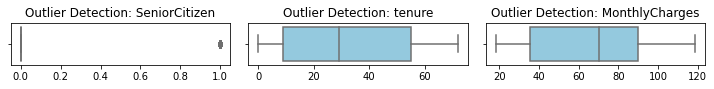

In [23]:
EDA(telecom_df)

### Data Preprocessing

In [24]:
# Treating Noise
telecom_df.TotalCharges = pd.to_numeric(telecom_df.TotalCharges, errors= "coerce")

In [25]:
# Dropping Null Values
telecom_df.dropna(inplace= True)

In [26]:
# Encoding the "SeniorCitizen" column
telecom_df.SeniorCitizen = np.where(telecom_df.SeniorCitizen == 0, "No", "Yes") 

In [27]:
# Dropping "customerID" column
telecom_df.drop(columns = "customerID", inplace = True)

In [28]:
# Dividing Data into Target Column ( Dependent Variable ) and Input Features (Independent Variable)
X = telecom_df.drop(columns = "Churn")
y = telecom_df.Churn.values

### Splitting Dataset

In [29]:
# Splitting into Train & Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .05, random_state= 40)

In [30]:
# Numerical Columns
num_cols = ["tenure", "TotalCharges", "MonthlyCharges"] 

# Categorical Columns
cat_cols = list(X_train.drop(columns=num_cols).columns)


In [31]:
# Label Encoding
for i in cat_cols :
    le = LabelEncoder()
      
    X_train[i] = le.fit_transform(X_train[i])
    X_test[i] = le.transform(X_test[i])


In [32]:
# Scaling Variable
StdScale = StandardScaler()
X_train.reset_index(drop= True, inplace= True)
X_train[num_cols] = pd.DataFrame(StdScale.fit_transform(X_train[num_cols]), columns= num_cols)
X_test.reset_index(drop= True, inplace= True)
X_test[num_cols] = pd.DataFrame(StdScale.transform(X_test[num_cols]), columns= num_cols)

In [33]:
# Balancing Data
smt = SMOTE(random_state=  42)
X_train , y_train = smt.fit_resample(X_train, y_train)

In [34]:
# All Algorithms With Train and Test Accuracy
result_df = BestAlgorithm(X_train, X_test, y_train, y_test)
result_df
result_df["Acc_Diff"] = result_df["Training Accuracy"] - result_df["Testing Accuracy"]

[LightGBM] [Info] Number of positive: 3925, number of negative: 3924
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 808
[LightGBM] [Info] Number of data points in the train set: 7849, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500064 -> initscore=0.000255
[LightGBM] [Info] Start training from score 0.000255
[LightGBM] [Info] Number of positive: 3924, number of negative: 3925
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 808
[LightGBM] [Info] Number of data points in the train set: 7849, number of used features: 19
[LightGBM] [Info] [binary:Bo

In [35]:
result_df

,Model,Best Parametres,Training Accuracy,Testing Accuracy,Acc_Diff
0,SVC,{'C': 0.5},0.786899,0.652893,0.134006
1,GBC,"{'n_estimators': 500, 'max_depth': 1, 'learnin...",0.786390,0.661224,0.125166
2,LightBGM_Class,"{'num_leaves': 2, 'n_estimators': 350, 'max_de...",0.784556,0.666667,0.117889
3,Random Forest,"{'n_estimators': 100, 'min_samples_split': 4, ...",0.769164,0.645914,0.123250


In [41]:
result_df.sort_values("Acc_Diff")

,Model,Best Parametres,Training Accuracy,Testing Accuracy,Acc_Diff
2,LightBGM_Class,"{'num_leaves': 2, 'n_estimators': 350, 'max_de...",0.784556,0.666667,0.117889
3,Random Forest,"{'n_estimators': 100, 'min_samples_split': 4, ...",0.769164,0.645914,0.123250
1,GBC,"{'n_estimators': 500, 'max_depth': 1, 'learnin...",0.786390,0.661224,0.125166
0,SVC,{'C': 0.5},0.786899,0.652893,0.134006


In [77]:
Best_Model = LGBMClassifier(**result_df.loc[result_df.Model == "LightBGM_Class", "Best Parametres"].values[0], random_state= 42)
Best_Model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 4906, number of negative: 4906
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 808
[LightGBM] [Info] Number of data points in the train set: 9812, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(max_depth=-7, n_estimators=350, num_leaves=2, random_state=42)

In [78]:
TrainPred = Best_Model.predict(X_train)
TestPred = Best_Model.predict(X_test)

In [79]:
TrainPred

array(['No', 'No', 'No', ..., 'Yes', 'No', 'No'], dtype=object)

In [80]:
from sklearn.metrics import accuracy_score

In [81]:
f1_score(y_train, TrainPred, pos_label= "Yes"), f1_score(y_test, TestPred, pos_label= "Yes")

(0.8016640866873065, 0.6666666666666666)

In [82]:
filename = "LightBGM_BestModel_Telecom.pkl"
pickle.dump(Best_Model, open(filename, "wb"))

In [ ]:
# X_train.head(2)
# np.where(y_train == "No", 0, 1)

In [94]:
# model1 = SVC(kernel = "rbf", random_state = 42, C= 0.01)

In [95]:
# from sklearn.metrics import make_scorer

In [96]:
# f1 = make_scorer(f1_score)

In [97]:
# scores = cross_val_score(model1, X_train, np.where(y_train == "No", 0, 1), cv = 5, scoring= f1)

In [98]:
# print("F1 score for each fold: ", scores)
# print("F1 Average Score: ", scores.mean())

In [99]:
# model1.fit(X_train, y_train)

In [100]:
# y_pred = model1.predict(X_test)
# test_f1 = f1_score(y_test, y_pred, pos_label= "Yes")

# print("Test F1 Score: ", test_f1)

In [101]:


# lgb = LGBMClassifier(
#     n_estimators=300,
#     learning_rate=0.05,
#     num_leaves=31,
#     max_depth=-1,
#     random_state=42
# )

# lgb.fit(X_train, y_train)
# pred_lgb = lgb.predict(X_test)

# print("LightGBM F1:", f1_score(y_test, pred_lgb, pos_label= "Yes"))

In [ ]:
# gb = GradientBoostingClassifier(
#     n_estimators=400,
#     learning_rate=0.05,
#     max_depth=1,
#     random_state=42
# )

In [ ]:
# from sklearn.metrics import classification_report

In [ ]:
# gb.fit(X_train, y_train)
# pred_gb = gb.predict(X_test)

# print(classification_report(y_test, pred_gb))
# print("Gradient Boosting F1:", f1_score(y_test, pred_gb, pos_label= "Yes"))


              precision    recall  f1-score   support

          No       0.95      0.71      0.81       513
         Yes       0.53      0.89      0.67       191

    accuracy                           0.76       704
   macro avg       0.74      0.80      0.74       704
weighted avg       0.83      0.76      0.77       704

Gradient Boosting F1: 0.665362035225049


In [ ]:
# pd.Series(y_train).value_counts()

No     4650
Yes    4650
Name: count, dtype: int64